In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot 
from scipy import interp
import scipy.stats
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

#### Goal
--------------------

The goal of this project is to make a classifier that predicts the final rankings for bakers.
The idea is to make a model for each episode and to use data from previous episodes in the model.
Therefore, a classifier for episode 1 will likely be bad at predicting the final outcome, but a classifier for episode 5 might accurately predict who will be in the top 3 and who might be eliminated in the next episode



#### Technical Challenge Rankings
--------------------------
* tech_med : median technical challenge ranking over each episode
* tech_mean : same as `tech_med` but the mean
* tech : technical challenge ranking for that episode

In [9]:
tech = pd.read_csv("../RESULTS/gbbo.techinical.data.20190907.tsv",sep='\t')
labs = label_binarize(tech['place'],sorted(list(set(tech['place']))))
tech['finalist'] = labs[:,0]+labs[:,1]
feats = ['tech_mean','tech_med','tech']

tech.head(10)

,season,baker,index,episode,tech_mean,tech_med,tech,place,finalist
0,1,Annetha,6,1,2.00,2.0,2,6,0
1,1,Annetha,6,2,4.50,4.5,7,6,0
2,1,Annetha,6,3,3.00,2.0,0,6,0
3,1,Annetha,6,4,2.25,1.0,0,6,0
4,1,Annetha,6,5,1.80,0.0,0,6,0
5,1,Annetha,6,6,1.50,0.0,0,6,0
6,1,David,4,1,3.00,3.0,3,4,0
7,1,David,4,2,5.50,5.5,8,4,0
8,1,David,4,3,5.00,4.0,4,4,0
9,1,David,4,4,5.00,4.5,5,4,0


In [10]:
from sklearn.preprocessing import QuantileTransformer
def quantile_scale(df):
    qua = df
    scaler = QuantileTransformer(
        n_quantiles=10,
        random_state=42,
        ignore_implicit_zeros=True, #sparse matrix
    )
    # fit the scaler
    scaler.fit(qua[feats])
    # transform values
    qua[feats] = scaler.transform(qua[feats])
    return qua

In [11]:
epi=sorted(list(set(tech['episode'])))
for x in epi:
    print('EPISODE:',x,
          '  Training Set Length: ',
          len(tech.loc[tech['episode']==x]))

EPISODE: 1   Training Set Length:  103
EPISODE: 2   Training Set Length:  103
EPISODE: 3   Training Set Length:  103
EPISODE: 4   Training Set Length:  103
EPISODE: 5   Training Set Length:  103
EPISODE: 6   Training Set Length:  103
EPISODE: 7   Training Set Length:  93
EPISODE: 8   Training Set Length:  93
EPISODE: 9   Training Set Length:  81
EPISODE: 10   Training Set Length:  81


In [13]:
# classifiers
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from collections import OrderedDict 
clfs = OrderedDict({
    'Linear SVM' : SVC(kernel='linear',probability=True),
    'RBF SVM' : SVC(kernel='rbf',probability=True),
    'SGD' : SGDClassifier(loss='log'),
    'KNN' : KNeighborsClassifier(),
    'Gaussian NB' : GaussianNB(),
    'Descision Trees' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(n_estimators=100),
    'Neural Network' : MLPClassifier(hidden_layer_sizes=(100),max_iter=1000) #0.001
})

In [42]:
def calc_95ci(a,confidence=0.95):
    a = 1.0 * np.array(a)
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

def return_training_test_sets(df,feats,season):
    test = df.loc[df['season']==season].sample(frac=1.) # shuffles the data
    train= df.loc[df['season']!=season].sample(frac=1.)
    X_test, y_test = test[feats], test['finalist']
    X_train, y_train = train[feats], train['finalist']
    return X_train,y_train, X_test,y_test
# LOO 
def gbbo_loo(df,clfs,feats):
    results={} #(episodes,classifiers) = [ ]
    # then once the results are evaluated, take the mean and 95% 
    seasons = sorted(list(set(df['season'])))
    episodes= sorted(list(set(df['episode'])))
    
    for e in episodes:
        # split test and training set
        tmp = df.loc[df['episode']==e]
        tmp = quantile_scale(tmp)
        print('EPISODE:',e)
        for clf_name in clfs:
            clf = clfs[clf_name]
            tprs, aucs, mean_fpr= [], [], np.linspace(0, 1, 100)

            for s in seasons:
                X_train, y_train, X_test, y_test = return_training_test_sets(tmp,feats,s)
                
                # skip if there are no episode data for the test season
                if len(X_test)==0: continue
                classes = sorted(list(set(y_train)))
                clf.fit(X_train,y_train)
                # calculate the probability for each class
                probs = clf.predict_proba(X_test)
                # calculate ROC curve
                fpr, tpr, thresholds = roc_curve(y_test,probs[:,1])
                # append to lists
                tprs.append(interp(mean_fpr, fpr, tpr))
                tprs[-1][0] = 0.0
                roc_auc = auc(fpr, tpr)
                aucs.append(roc_auc)
            # calculate mean and 95% confidence intervals
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            ci_auc = calc_95ci(aucs)
            ci_tpr = calc_95ci(tprs)
            tprs_upper = np.minimum(mean_tpr + ci_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - ci_tpr, 0)
            # save results for later plotting
            results[(e,clf_name)]=(mean_fpr, mean_tpr,mean_auc,ci_auc,tprs_upper,tprs_lower)
    
    return results          

In [43]:
# since tech_mean and tech_med are highly correlated, we will only train
# on tech_mean since the data is normally distributed

feats = ['tech_mean','tech']
results = gbbo_loo(tech,clfs,feats)

EPISODE: 1
EPISODE: 2
EPISODE: 3
EPISODE: 4
EPISODE: 5
EPISODE: 6
EPISODE: 7
EPISODE: 8
EPISODE: 9
EPISODE: 10


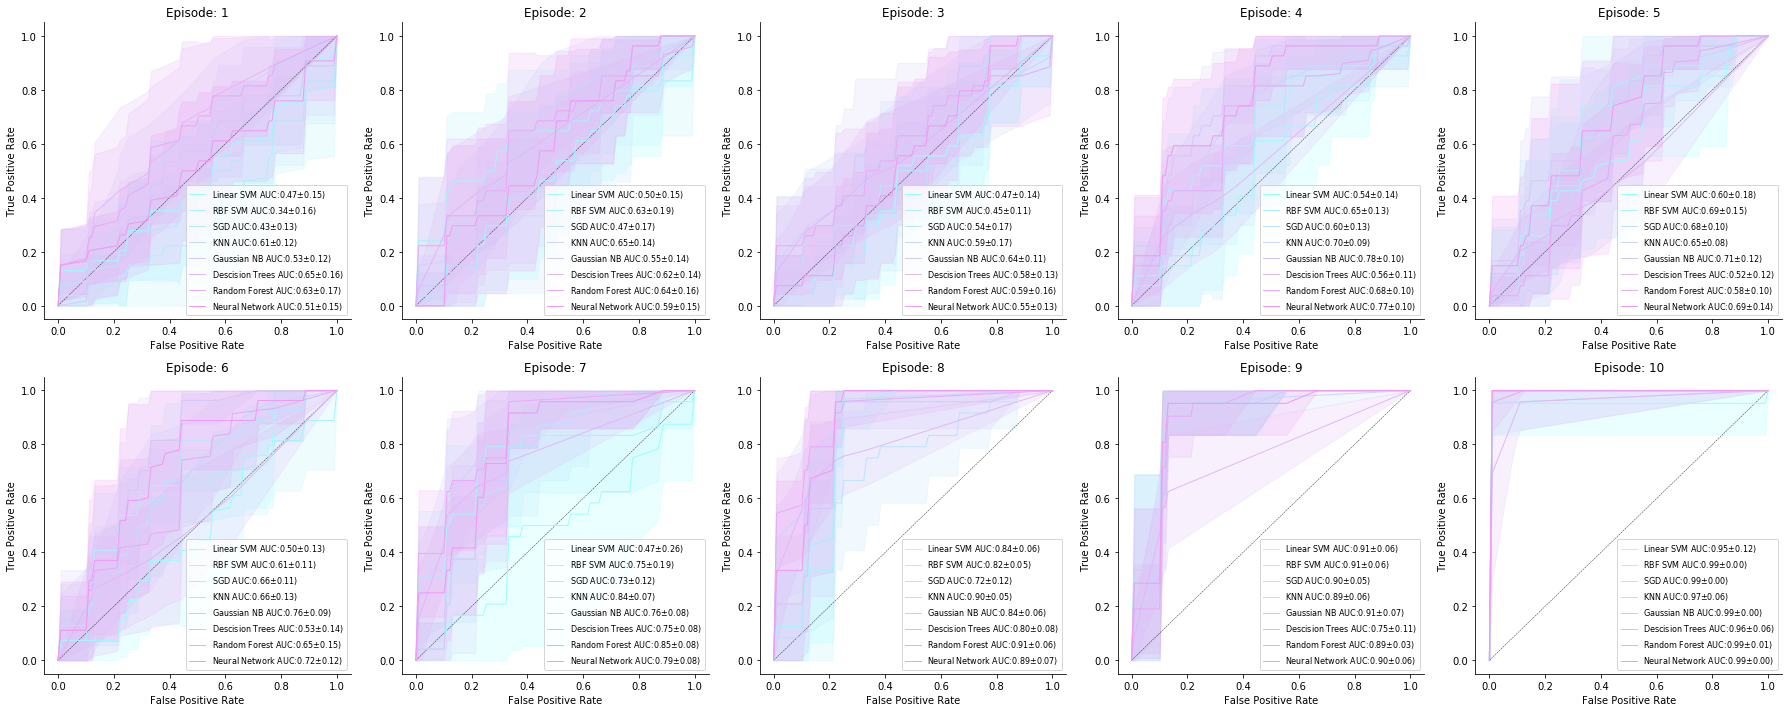

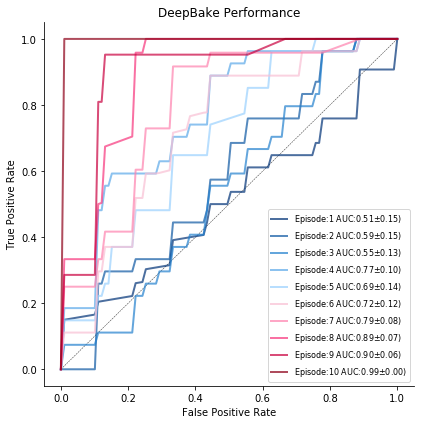

In [44]:
# plot results
from datetime import datetime
def timestamp(): return datetime.today().strftime('%Y%m%d')
def format_roc_plot(ax):
    vapeplot.despine(ax)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right",fontsize=8) 
    
def plot_results(results,episodes,axes):
    colr = ['#96ffff', '#aaf2fd', '#bae4fc', '#c9d6fa', '#d5c8f8', '#e0b9f7', '#e9aaf5', '#f299f3']
    for e,ax in zip(episodes,axes.flatten()):
        # plot the chance line
        ax.plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',alpha=.8)    

        for c,clf_name in zip(colr,list(clfs.keys())):
            mean_fpr, mean_tpr,mean_auc,ci_auc,tprs_upper,tprs_lower = results[(e,clf_name)]
            ax.plot(mean_fpr, mean_tpr, color=c,label=r'%s AUC:%0.2f$\pm$%0.2f)' % (clf_name,mean_auc, ci_auc),lw=1)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=c, alpha=.2)
        format_roc_plot(ax)
        ax.set_title('Episode: {}'.format(e))
# plot only the Neual Network
def plot_nn_results(results,episodes,ax):
    colr = ['#003277', '#0e58a3', '#2380ce', '#5ba9e9', '#9ad1fe', '#f9bfd4', '#fe82ae', '#f7357c', '#c9003f', '#8e0018']
    # plot the chance line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',alpha=.8)    
    clf_name = 'Neural Network'
    for c,e in zip(colr,episodes): 
        mean_fpr, mean_tpr,mean_auc,ci_auc,tprs_upper,tprs_lower = results[(e,clf_name)]
        ax.plot(mean_fpr, mean_tpr, color=c,label=r'Episode:%s AUC:%0.2f$\pm$%0.2f)' % (e,mean_auc, ci_auc),lw=2,alpha=0.7)
        #ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=c, alpha=.2)
    format_roc_plot(ax)
    ax.set_title('DeepBake Performance')
    
n_rows = 2
episodes = sorted(list(set(tech['episode'])))
n_cols = int(len(episodes)/2)
sz = 5
f, axes = plt.subplots(n_rows,n_cols,figsize=(n_cols*sz,n_rows*sz))
plot_results(results,episodes,axes)   
f.tight_layout()
f.savefig("../FIGURES/gbbo.technical.loo.norm.finalistclf.results.{}.png".format(timestamp()),dpi=500)
f.show()

f, ax = plt.subplots(1,1,figsize=(6,6))
plot_nn_results(results,episodes,ax)
f.tight_layout()
f.savefig("../FIGURES/gbbo.technical.loo.norm.finalist.deepbake.results.{}.png".format(timestamp()),dpi=500)
f.show()